# Forecasting and Predicting the Furniture Sales of a Superstore

We are using Superstore sales data for furniture sales between 2014 to 2017 and apply a simple model to forecast for 2018

## Content

1. **[Import packages](#import_packages)**
2. **[Load data](#load_data)**
3. **[Data preparation](#data_preparation)**
    - 3.1 - [Dimensions of Dataset](#data_dimension)
    - 3.2 - [Statistical Summary](#Stat_sum)
    - 3.3 - [Checking Data Type and Missing Values](#check_data_type)
4. **[Visualizing Furniture Sales Time Series Data](#exploratory_data_analysis)**
    - 4.1 - [Checking Stationarity](#Checking_Stationarity)
    - 4.2 - [Decomposing](#Decomposing)
5. **[Forecasting](#Forecasting)**
    - 5.1 - [Time Series Forecasting using ARIMA](#Time_Series_Forcasting_using_ARIMA)
    - 5.2 - [Parameter Selection](#Parameter_Selection)
    - 5.3 - [Fitting the ARIMA model](#Fitting_the_ARIMA)
    - 5.4 - [Validating Forecasts](#Validating_Forecasts)
    - 5.5 - [Visualizing the Forecast](#Visualizing_the_Forecast)

<a id='import_packages'></a>
# Import Packages

In [33]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

<a id='load_data'></a>
# Load Data

In [34]:

import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_db221c9083da49bda597e7df5fb8517c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ztvuwmXsgiz2MMSqWErcIYDe0fm2k9Qx08YFU4asfx-P',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_db221c9083da49bda597e7df5fb8517c.get_object(Bucket='timeseries-donotdelete-pr-jsyogp3niusggu',Key='Super Store.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

furniture = pd.read_csv(body, encoding='cp1252')
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


<a id='data_preparation'></a>
# Data Preparation

<a id='data_dimension'></a>
# 3.1 Dimensions of Dataset
We get a quick idea of how many instances (rows) and how many attributes (columns) the data contains with the shape property.

In [35]:
# Checking structure of the data
furniture.shape

(2121, 21)

<a id='Stat_sum'></a>
# 3.2 Statistical Summary
Here we take a look at the summary of each attribute.

This includes the count, mean, the min and max values as well as percentiles.

In [36]:
furniture.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,55726.556341,349.834887,3.785007,0.173923,8.699327
std,2885.740258,32261.888225,503.179145,2.251620,0.181547,136.049246
min,1.000000,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,99301.000000,4416.174000,14.000000,0.700000,1013.127000


<a id='check_data_type'></a>
## 3.3 Checking Data Type and Missing Values 

In [37]:
# summary of the data 
furniture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
Row ID           2121 non-null int64
Order ID         2121 non-null object
Order Date       2121 non-null object
Ship Date        2121 non-null object
Ship Mode        2121 non-null object
Customer ID      2121 non-null object
Customer Name    2121 non-null object
Segment          2121 non-null object
Country          2121 non-null object
City             2121 non-null object
State            2121 non-null object
Postal Code      2121 non-null int64
Region           2121 non-null object
Product ID       2121 non-null object
Category         2121 non-null object
Sub-Category     2121 non-null object
Product Name     2121 non-null object
Sales            2121 non-null float64
Quantity         2121 non-null int64
Discount         2121 non-null float64
Profit           2121 non-null float64
dtypes: float64(3), int64(3), object(15)
memory usage: 348.1+ KB


Checking the furniture sales time stamp

In [38]:
furniture['Order Date'].min(), furniture['Order Date'].max()

('1/1/2017', '9/9/2017')

We remove the columns that we do not need as well as check missing values

In [39]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

Aggregate sales data by date

In [40]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

Indexing with the Time Series Data

In [41]:
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])
furniture.set_index('Order Date', inplace=True)
furniture.index

DatetimeIndex(['2017-01-01', '2014-01-10', '2015-01-10', '2016-01-10',
               '2014-01-11', '2016-01-11', '2017-01-12', '2014-01-13',
               '2015-01-13', '2017-01-13',
               ...
               '2014-09-07', '2015-09-07', '2017-09-07', '2014-09-08',
               '2015-09-08', '2016-09-08', '2017-09-08', '2014-09-09',
               '2016-09-09', '2017-09-09'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Resampling the datetime data. Here we use the start of each month as the timestamp and take the average daily sales value for a particular month since working with the current datetime data becomes tricky

In [42]:
furniture.head()

,Sales
Order Date,
2017-01-01,975.490
2014-01-10,51.940
2015-01-10,1018.104
2016-01-10,104.770
2014-01-11,9.940


In [43]:
y = furniture['Sales'].resample('MS').mean()

Taking a look at the furniture sales data for the year 2017

In [44]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

<a id='exploratory_data_analysis'></a>
# Visualizing Furniture Sales Time Series Data

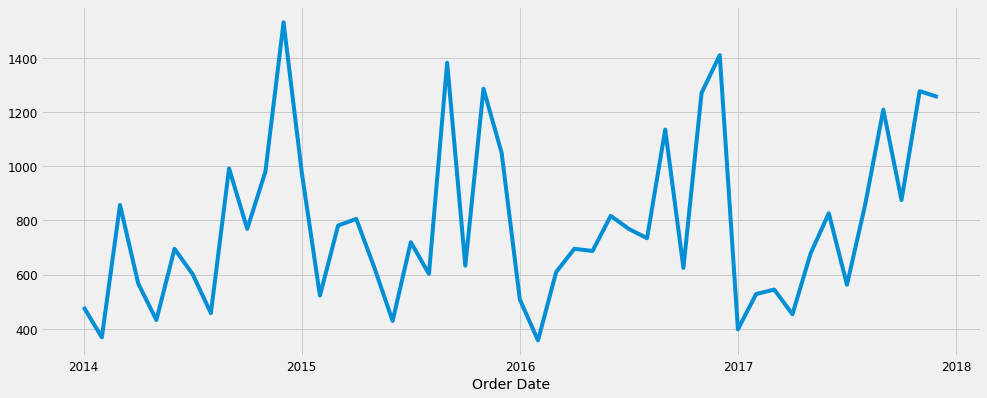

In [45]:
y.plot(figsize=(15, 6))
plt.show()

The plot clearly indicates that the time series has seasonality pattern.The sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year

<a id='Checking_Stationarity'></a>
# Checking Stationarity

Our first step in time-series analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them. Augmented Dickey-Fuller(ADF) statistics is one of the more widely used statistical test to check whether your time series is stationary or non-stationary. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). 
The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [46]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
#series = Series.from_csv('daily-total-female-births.csv', header=0)
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.191070
p-value: 0.000009
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


We can see that our statistic value of -4.756843 is less than the value of -3.578 at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

The p-value is 0.000009, which is way below the threshold (0.05). Hence the null-hypothesis is rejected. It suggests the time series does not have a unit root, meaning it is stationary.

<a id='Decomposing'></a>
# Decomposing
Decomposing the time series into three distinct components: trend, seasonality, and noise.

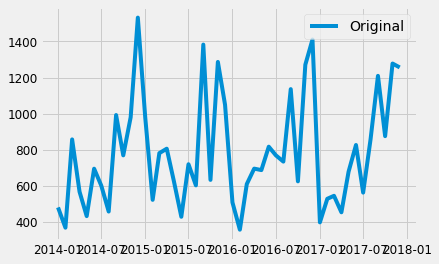

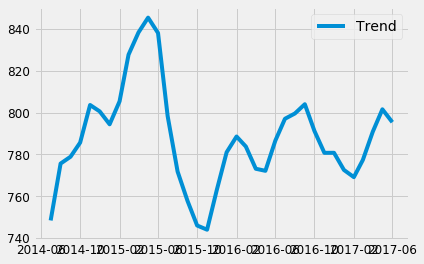

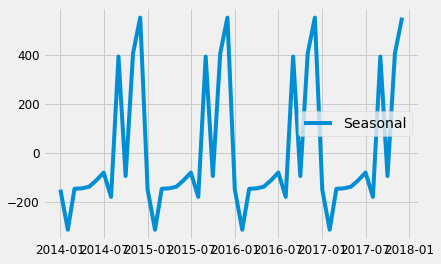

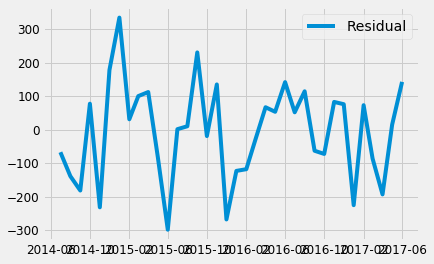

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

plt.plot(y, label = 'Original')
plt.legend(loc = 'best')

trend = decomposition.trend
plt.show()
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

seasonal = decomposition.seasonal
plt.show()
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

residual = decomposition.resid
plt.show()
plt.plot(residual, label = 'Residual')
plt.legend(loc='best')

By visualizing the decomposed components of the original time series we can say that the sales of furniture is unstable, along with its obvious seasonality.

<a id='Forecasting'></a>
# Forecasting

<a id='Time_Series_Forcasting_using_ARIMA'></a>
# Time Series Forecasting using ARIMA
We will use ARIMA for forecasting our time series. ARIMA is also denoted as ARIMA(p,d,q) where p,d,q accounts for seasonality, trend and noise in the time series data

In [48]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


<a id='Parameter_Selection'></a>
# Parameter Selection 
We use “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [49]:
from pylab import rcParams
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param,
seasonal_order=param_seasonal,
enforce_stationarity=False, 
enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1309.8667694524042
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1057.7887021717788
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.00471991163414
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758112
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4123.88163289001
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.560742980912
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.53990100718494
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2517.812415549242
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1314.9323479856366
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1355.3563924341877
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817236
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3029.634930303895
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484828363
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774428423
ARIM

<a id='Fitting_the_ARIMA'></a>
# Fitting the ARIMA model

In [50]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


Running model diagnostiscs to check any unusual behaviour

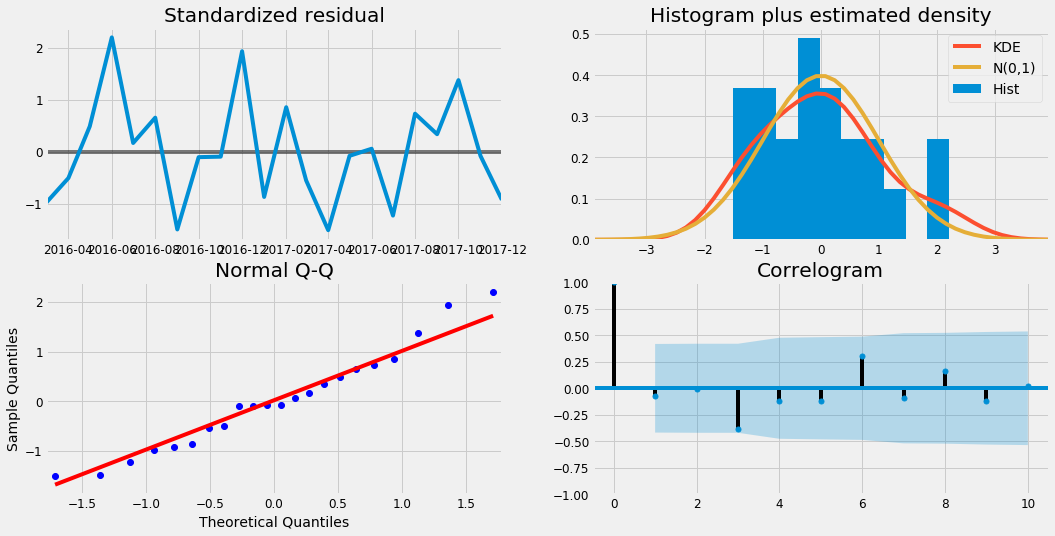

In [51]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Standardized Residual : The residuals scatters around a mean near zero, as they should, with no obvious trends or patterns indicating misspecification.

Histogram plus estimated density: The data distribution is nearly normal.

Normal Q-Q : The plots show sample quantiles versus theoretical quantiles. Those are the quantiles from the standard Normal distribution with mean 0 and standard deviation 1. The points seem to fall about a straight line. This graphs to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential

Correlogram : There is no evidence of autocorrelation outside of the Bartlett two-standard-error bands for white noise, given by the blue lines.

The model diagnostics indicates that the model residuals are near normally distributed

The model diagnostics indicates that the model residuals are near normally distributed

<a id = 'Validating_Forecasts'></a>
# Validating Forecasts
We compare predicted sales to real sales of the time series to understand the accuracy of our forecasts

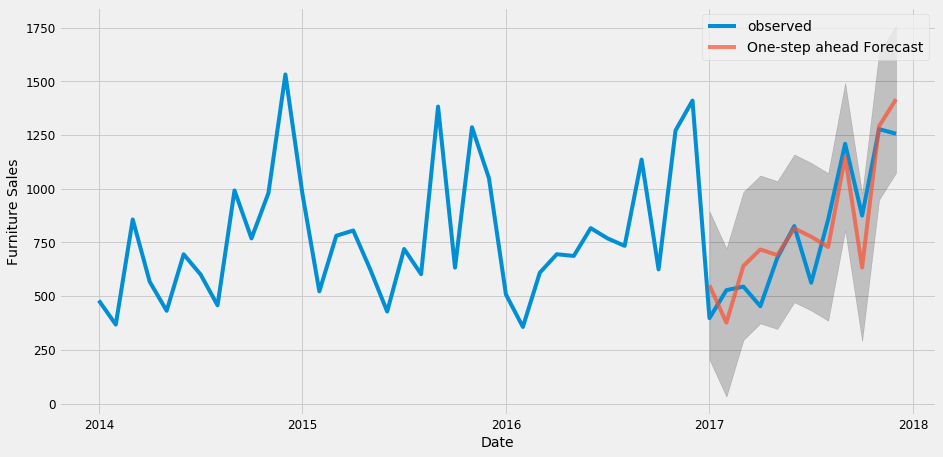

In [52]:
#set forecasts to start at 2017–01–01 to the end of the data to forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The above plot indicates the observed value and the rolling forecast predications (A rolling forecast is an add/drop process for predicting the future over a set period of time). The predicated values align well with the true values.

# Calculating RMSE

In [53]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


RMSE tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales.

<a id ='Visualizing_the_Forecast'></a>
# Visualizing the Forecast 

            lower Sales  upper Sales
2018-01-01    66.439788   751.053580
2018-02-01   191.940526   876.931645
2018-03-01   214.443266   899.438913
2018-04-01   127.554398   812.550111
2018-05-01   346.657696  1031.653410
2018-06-01   494.347026  1179.342740
2018-07-01   235.873484   920.869198
2018-08-01   522.882144  1207.877859
2018-09-01   875.775044  1560.770758
2018-10-01   537.150160  1222.145874
2018-11-01   945.782384  1630.778099
2018-12-01   928.336248  1613.331962
2019-01-01   -66.357142   904.538940


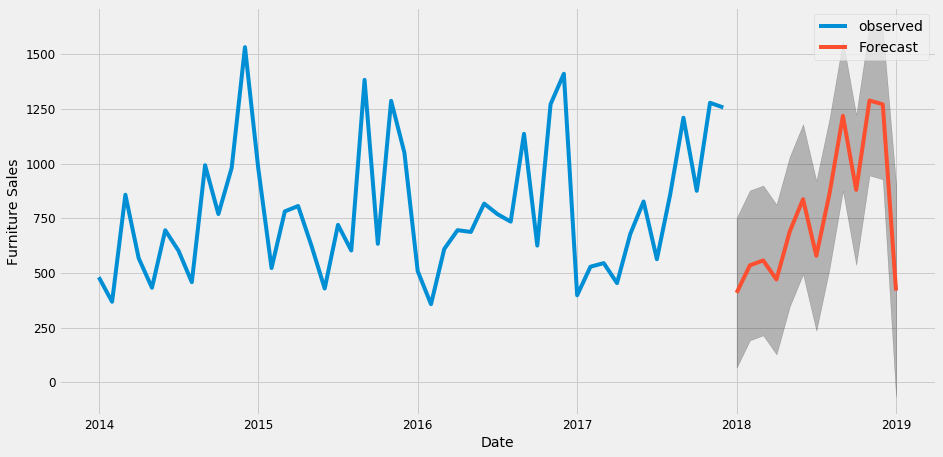

In [54]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
print(pred_ci)
plt.legend()
plt.show()

# Conclusion

We observe that sales of furniture produces seasonal pattern. Early of the year is the off season for furniture sales in the superstore. The sales for furniture increases linearly over time in a year.